In [2]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import seaborn as sns
import numpy as np
from scipy.stats import norm
import timeit


## Constraints:
- Demand should be satisfied during lead time: demand ≤ 𝜎 * lead time. This implies the safety stock should be enough to cover the demand variability during lead time.
- Lead time should be within the given lead time for each product: LT ≤ lead time
- Inventory should be sufficient to meet the demand: starting stock + ∑(𝑄) − ∑(demand) ≥ 0
- Order Quantity Constraints: minimum order quantity (𝑄 ≥ 20% * average demand), maximum order quantity (𝑄 ≤ 50% * average demand)

To optimize the safety stock calculation and obtain optimal solutions, the following improvements were performed:

- Dynamic Z-score Calculation: Instead of using a fixed Z-score like 1.65, the program dynamically calculates the Z-score based on the desired service level or confidence level. This allows for flexibility in setting the appropriate level of risk tolerance.

- Refined Demand Distribution: Rather than relying on a simple mixture of two normal distributions, used historical demand data to fit a more accurate demand distribution, such as a normal distribution or another appropriate probability distribution. This ensures that the demand variability is adequately captured.

- Simulation-based Optimization: simulation-based optimization algorithms to iteratively adjust parameters (e.g., reorder quantity, safety stock level) to maximize expected profit while meeting service level constraints and minimizing costs.

## Periodic review

**safety_stock = (max_daily_sales * max_lead_time) - (avg_daily_sales * avg_lead_time)**

In [ ]:
start = timeit.default_timer()

def calculate_safety_stock(max_daily_sales, max_lead_time, avg_daily_sales, avg_lead_time):
    safety_stock = (max_daily_sales * max_lead_time) - (avg_daily_sales * avg_lead_time)
    return safety_stock

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785]
}

class Product:
    def __init__(self, i):
        self.mean = np.mean([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.sd = np.std([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.mean_demand_lead_time = summary['Mean Demand (Lead Time)'][i - 1]
        self.std_dev_demand_lead_time = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.expected_demand_lead_time = summary['Expected Demand (Lead Time)'][i - 1]

def daily_demand(mean, sd, probability):
    if np.random.uniform(0, 1) > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(Q, product, review_period=30, z_score=1.65):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.expected_demand_lead_time  # Corrected attribute name

    """
    - Importance sampling parameters
    - Define a new distribution that emphasizes extreme demand values
    - For simplicity, we used a mixture of two normal distributions
    - One centered around the mean and another centered around a high demand value
    """
    high_demand_value = 2 * mean
    weights = [0.8, 0.2]
    means = [mean, high_demand_value]
    sds = [sd, sd]

    # max_daily_sales and avg_daily_sales
    daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]
    max_daily_sales = np.max(daily_sales)
    avg_daily_sales = np.mean(daily_sales)

    # max_lead_time and avg_lead_time
    max_lead_time = lead_time
    avg_lead_time = np.mean(summary['Lead Time'])

    # safety stock
    safety_stock = calculate_safety_stock(max_daily_sales, max_lead_time, avg_daily_sales, avg_lead_time)


    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'reorder_quantities': []}  # Added 'reorder_quantities'

    for day in range(1, 365):
        # Sample demand from the new distribution
        day_demand = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]  # Corrected list comprehension
        if day_demand != 0:  # Add this condition to skip printing when demand is zero
            data['daily_demand'].append(day_demand)

        if day % review_period == 0:

            q = max(0, safety_stock + demand_lead - inventory)
            q = max(q, int(0.2 * mean))  # Minimum order quantity
            order_placed = True
            data['orders'].append(q)
            data['reorder_quantities'].append(q)  # Store reorder quantity

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        for demand in day_demand:  # Iterate over each demand value for the current day
            if inventory - demand >= 0:
                data['units_sold'].append(demand)
                inventory -= demand
            else:
                data['units_sold'].append(inventory)
                data['units_lost'].append(demand - inventory)
                inventory = 0
                stock_out += 1

            data['inv_level'].append(inventory)

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

products = [Product(i) for i in range(1, 5)]
results = {}

for product in products:
    profit_list = []
    lost_orders_list = []
    reorder_quantities = []
    for _ in range(1000):
        data = MCS(Q=10000, product=product)
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        lost_orders_list.append(len(data['units_lost']) / 365)
        reorder_quantities.extend(data['reorder_quantities'])
    results[f'Pr{product.i}'] = {
        'profits': profit_list,
        'mean_profit': np.mean(profit_list),
        'std_dev_profit': np.std(profit_list),
        'lost_order_proportion': np.mean(lost_orders_list),
        'reorder_quantity': np.mean(reorder_quantities),
        'average_safety_stock': np.mean(safety_stocks)
    }

for key, value in results.items():
    print(f"Product {key}:")
    print(f"  Mean Profit: {value['mean_profit']}")
    print(f"  Profit Std Dev: {value['std_dev_profit']}")
    print(f"  Proportion of Lost Orders: {value['lost_order_proportion']}")
    print(f"  Average Reorder Quantity: {value['reorder_quantity']}\n")
    print(f"  Average Safety Stock: {value['average_safety_stock']}\n")

stop = timeit.default_timer()
print('Time: ', stop - start)

**safety_stock = z * std_dev_daily_sales * np.sqrt(lead_time)**

In [20]:
start = timeit.default_timer()

def calculate_safety_stock(z, std_dev_daily_sales, lead_time):
    safety_stock = z * std_dev_daily_sales * np.sqrt(lead_time)
    return safety_stock

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785]
}

class Product:
    def __init__(self, i):
        self.mean = np.mean([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.sd = np.std([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.mean_demand_lead_time = summary['Mean Demand (Lead Time)'][i - 1]
        self.std_dev_demand_lead_time = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.expected_demand_lead_time = summary['Expected Demand (Lead Time)'][i - 1]

def daily_demand(mean, sd, probability):
    if np.random.uniform(0, 1) > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS(Q, product, review_period=30, z_score=1.65):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.expected_demand_lead_time  # Corrected attribute name

    """
    - Importance sampling parameters
    - Define a new distribution that emphasizes extreme demand values
    - For simplicity, we used a mixture of two normal distributions
    - One centered around the mean and another centered around a high demand value
    """

    high_demand_value = 2 * mean
    weights = [0.8, 0.2]
    means = [mean, high_demand_value]
    sds = [sd, sd]  # Assuming same standard deviation for simplicity

    # max_daily_sales and avg_daily_sales
    daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]  # Corrected list comprehension
    max_daily_sales = np.max(daily_sales)
    avg_daily_sales = np.mean(daily_sales)

    # max_lead_time and avg_lead_time
    max_lead_time = lead_time
    avg_lead_time = np.mean(summary['Lead Time'])

    # max_daily_sales and avg_daily_sales
    daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]
    std_dev_daily_sales = np.std(daily_sales)


    safety_stock = calculate_safety_stock(z_score, std_dev_daily_sales, lead_time)


    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'reorder_quantities': []}

    for day in range(1, 365):

        day_demand = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]
        if day_demand != 0:
            data['daily_demand'].append(day_demand)

        if day % review_period == 0:

            q = max(0, safety_stock + demand_lead - inventory)
            q = max(q, int(0.2 * mean))  # Minimum order quantity
            order_placed = True
            data['orders'].append(q)
            data['reorder_quantities'].append(q)  # Store reorder quantity

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        for demand in day_demand:
            if inventory - demand >= 0:
                data['units_sold'].append(demand)
                inventory -= demand
            else:
                data['units_sold'].append(inventory)
                data['units_lost'].append(demand - inventory)
                inventory = 0
                stock_out += 1

            data['inv_level'].append(inventory)

    return data

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

products = [Product(i) for i in range(1, 5)]
results = {}
for product in products:
    profit_list = []
    lost_orders_list = []
    reorder_quantities = []
    for _ in range(1000):
        data = MCS(Q=10000, product=product)
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        lost_orders_list.append(len(data['units_lost']) / 365)
        reorder_quantities.extend(data['reorder_quantities'])
    results[f'Pr{product.i}'] = {
        'profits': profit_list,
        'mean_profit': np.mean(profit_list),
        'std_dev_profit': np.std(profit_list),
        'lost_order_proportion': np.mean(lost_orders_list),
        'reorder_quantity': np.mean(reorder_quantities),
        'average_safety_stock': np.mean(safety_stocks)
    }

for key, value in results.items():
    print(f"Product {key}:")
    print(f"  Mean Profit: {value['mean_profit']}")
    print(f"  Profit Std Dev: {value['std_dev_profit']}")
    print(f"  Proportion of Lost Orders: {value['lost_order_proportion']}")
    print(f"  Average Reorder Quantity: {value['reorder_quantity']}\n")
    print(f"  Average Safety Stock: {value['average_safety_stock']}\n")

stop = timeit.default_timer()
print('Time: ', stop - start)

Product Pr1:
  Mean Profit: 52904.03510031626
  Profit Std Dev: 43.943712795284995
  Proportion of Lost Orders: 360.30688767123286
  Average Reorder Quantity: 717.937008605229

  Average Safety Stock: 15.182317257621888

Product Pr2:
  Mean Profit: 213975.32688399803
  Profit Std Dev: 42.16831598845896
  Proportion of Lost Orders: 345.93464383561644
  Average Reorder Quantity: 3904.328303628147

  Average Safety Stock: 15.182317257621888

Product Pr3:
  Mean Profit: 125007.68770470977
  Profit Std Dev: 62.96578839838402
  Proportion of Lost Orders: 355.055301369863
  Average Reorder Quantity: 2285.701324064281

  Average Safety Stock: 15.182317257621888

Product Pr4:
  Mean Profit: 312181.31929155724
  Profit Std Dev: 223.67535328993208
  Proportion of Lost Orders: 360.51463287671237
  Average Reorder Quantity: 800.2280263846296

  Average Safety Stock: 15.182317257621888

Time:  1194.5292679960003


## Plot (Pr1)

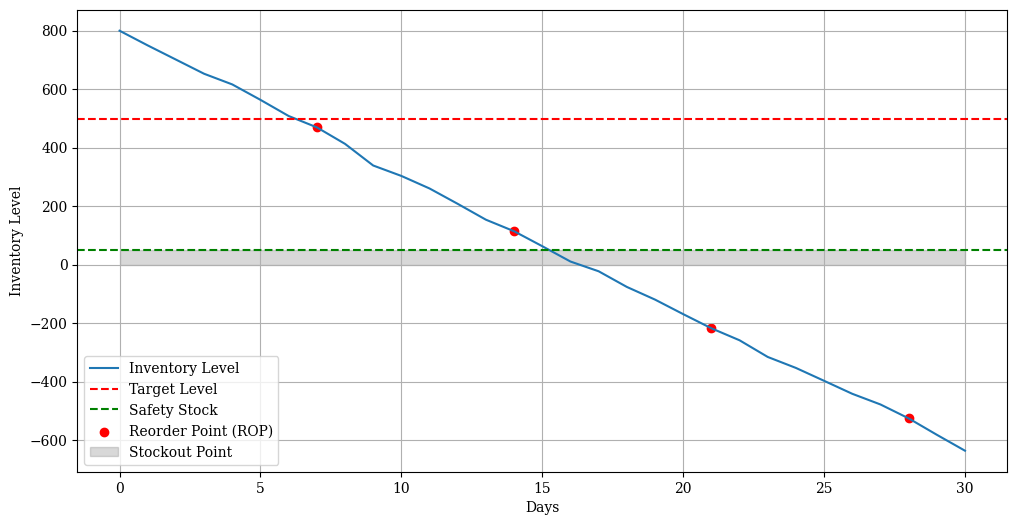

In [29]:
review_period = 7
lead_time = 9
z_score = 1.65
demand_mean = 50
demand_std = 10
initial_inventory = 800

expected_demand_during_lead_time = demand_mean * lead_time
safety_stock = z_score * demand_std * np.sqrt(lead_time)

target_level = expected_demand_during_lead_time + safety_stock

days = 30
inventory_levels = [initial_inventory] + [0] * (days + lead_time)
orders = []
reorder_points = []
safety_stocks = [safety_stock]
stockouts = []

for day in range(1, days + 1):

    daily_demand = np.random.normal(demand_mean, demand_std)
    if daily_demand < 0:
        daily_demand = 0

    inventory_levels[day] = inventory_levels[day - 1] - daily_demand

    if day % review_period == 0:
        # inventory position (current inventory + orders placed but not yet received)
        inventory_position = inventory_levels[day]

        # order quantity required to reach the target level
        order_quantity = target_level - inventory_position
        if order_quantity < 0:
            order_quantity = 0

        orders.append(order_quantity)
        reorder_points.append(inventory_levels[day])

        if day + lead_time <= days:
            inventory_levels[day + lead_time] += order_quantity

    else:
        orders.append(0)
        reorder_points.append(None)


    safety_stocks.append(safety_stock)
    stockouts.append(0)


inventory_levels = inventory_levels[:days + 1]

plt.figure(figsize=(12, 6))
plt.plot(range(days + 1), inventory_levels, label='Inventory Level')
plt.axhline(y=target_level, color='red', linestyle='--', label='Target Level')
plt.axhline(y=safety_stock, color='green', linestyle='--', label='Safety Stock')
plt.scatter(range(1, days + 1), reorder_points, color='red', label='Reorder Point (ROP)')
plt.fill_between(range(days + 1), 0, safety_stock, color='gray', alpha=0.3, label='Stockout Point')
plt.xlabel('Days')
plt.ylabel('Inventory Level')
plt.title('Inventory Levels in a Periodic Review System')
plt.legend()
plt.grid(True)
plt.show()


## continuous review
The logic of the continuous review:
- the safety stock is calculated using the standard deviation of daily sales and the lead time.
- the reorder point is then determined as the sum of safety stock and the expected demand during the lead time.
- the inventory level is checked daily. If the inventory level falls below or equals the reorder point and no order is currently placed, an order is triggered.
- the order quantity (q) is calculated to bring the inventory back up to the safety stock level plus expected demand during the lead time, ensuring a minimum order quantity.
- order is placed, and a counter starts to track the lead time for the order arrival. When the counter reaches the lead time, the ordered quantity is added to the inventory, and the counter is reset.

In [19]:
start = timeit.default_timer()

def calculate_safety_stock(z, std_dev_daily_sales, lead_time):
    safety_stock = z * std_dev_daily_sales * np.sqrt(lead_time)
    return safety_stock

summary = {
    'Purchase Cost': [12, 7, 6, 37],
    'Lead Time': [9, 6, 15, 12],
    'Size': [0.57, 0.05, 0.53, 1.05],
    'Selling Price': [16.10, 8.60, 10.20, 68],
    'Starting Stock': [2750, 22500, 5200, 1400],
    'Ch': [0.2 * 12, 0.2 * 7, 0.2 * 6, 0.2 * 37],
    'Co': [1000, 1200, 1000, 1200],
    'Probability': [0.76, 1.00, 0.70, 0.23],
    'Mean Demand (Lead Time)': [103.50, 648.55, 201.68, 150.06],
    'Std. Dev. of Demand (Lead Time)': [37.32, 26.45, 31.08, 3.21],
    'Expected Demand (Lead Time)': [705, 3891, 2266, 785]
}

class Product:
    def __init__(self, i):
        self.mean = np.mean([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.sd = np.std([np.log(j) for j in [summary['Expected Demand (Lead Time)'][i - 1]] if j > 0])
        self.i = i
        self.unit_cost = summary['Purchase Cost'][i - 1]
        self.lead_time = summary['Lead Time'][i - 1]
        self.size = summary['Size'][i - 1]
        self.selling_price = summary['Selling Price'][i - 1]
        self.holding_cost = summary['Ch'][i - 1]
        self.ordering_cost = summary['Co'][i - 1]
        self.probability = summary['Probability'][i - 1]
        self.starting_stock = summary['Starting Stock'][i - 1]
        self.mean_demand_lead_time = summary['Mean Demand (Lead Time)'][i - 1]
        self.std_dev_demand_lead_time = summary['Std. Dev. of Demand (Lead Time)'][i - 1]
        self.expected_demand_lead_time = summary['Expected Demand (Lead Time)'][i - 1]

def daily_demand(mean, sd, probability):
    if np.random.uniform(0, 1) > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

def MCS_continuous(Q, product, z_score=1.65, min_order_quantity=10):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.expected_demand_lead_time

    high_demand_value = 2 * mean
    weights = [0.8, 0.2]
    means = [mean, high_demand_value]
    sds = [sd, sd]

    daily_sales = [np.random.normal(means[i], sds[i]) for i in np.random.choice(len(weights), size=365, p=weights)]
    std_dev_daily_sales = np.std(daily_sales)

    safety_stock = calculate_safety_stock(z_score, std_dev_daily_sales, lead_time)
    reorder_point = safety_stock + demand_lead

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'reorder_quantities': []}

    total_safety_stock = 0

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if inventory <= reorder_point and not order_placed:
            q = max(safety_stock + demand_lead - inventory, min_order_quantity)
            order_placed = True
            data['orders'].append(q)
            data['reorder_quantities'].append(q)

        if order_placed:
            counter += 1

        if counter == lead_time:
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        else:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)
        total_safety_stock += safety_stock

    average_safety_stock = total_safety_stock / 365

    return data, average_safety_stock

def profit_calculation(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size / days
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

products = [Product(i) for i in range(1, 5)]
results = {}
for product in products:
    profit_list = []
    lost_orders_list = []
    reorder_quantities = []
    safety_stocks = []
    for _ in range(1000):
        data, avg_safety_stock = MCS_continuous(Q=10000, product=product)
        profit = profit_calculation(data, product)
        profit_list.append(profit)
        lost_orders_list.append(len(data['units_lost']) / 365)
        reorder_quantities.extend(data['reorder_quantities'])
        safety_stocks.append(avg_safety_stock)
    results[f'Pr{product.i}'] = {
        'profits': profit_list,
        'mean_profit': np.mean(profit_list),
        'std_dev_profit': np.std(profit_list),
        'lost_order_proportion': np.mean(lost_orders_list),
        'reorder_quantity': np.mean(reorder_quantities),
        'average_safety_stock': np.mean(safety_stocks)
    }

for key, value in results.items():
    print(f"Product {key}:")
    print(f"  Mean Profit: {value['mean_profit']}")
    print(f"  Profit Std Dev: {value['std_dev_profit']}")
    print(f"  Proportion of Lost Orders: {value['lost_order_proportion']}")
    print(f"  Average Reorder Quantity: {value['reorder_quantity']}")
    print(f"  Average Safety Stock: {value['average_safety_stock']}\n")

stop = timeit.default_timer()
print('Time: ', stop - start)

Product Pr1:
  Mean Profit: 90672.06485483673
  Profit Std Dev: 7077.518592965281
  Proportion of Lost Orders: 0.6648
  Average Reorder Quantity: 567.8196263242743
  Average Safety Stock: 12.927029932529585

Product Pr2:
  Mean Profit: 457237.94674979424
  Profit Std Dev: 21.21666452531733
  Proportion of Lost Orders: 0.8246575342465755
  Average Reorder Quantity: 3847.1431273046364
  Average Safety Stock: 13.304984563256864

Product Pr3:
  Mean Profit: 192279.68125035317
  Profit Std Dev: 15842.809625483307
  Proportion of Lost Orders: 0.6433671232876712
  Average Reorder Quantity: 1745.5783059615346
  Average Safety Stock: 19.68444451839142

Product Pr4:
  Mean Profit: 435257.5629101204
  Profit Std Dev: 31456.090446069993
  Proportion of Lost Orders: 0.19104109589041096
  Average Reorder Quantity: 441.15621473851667
  Average Safety Stock: 15.182317257621888

Time:  18.35062900199955


## Plot (Pr1)

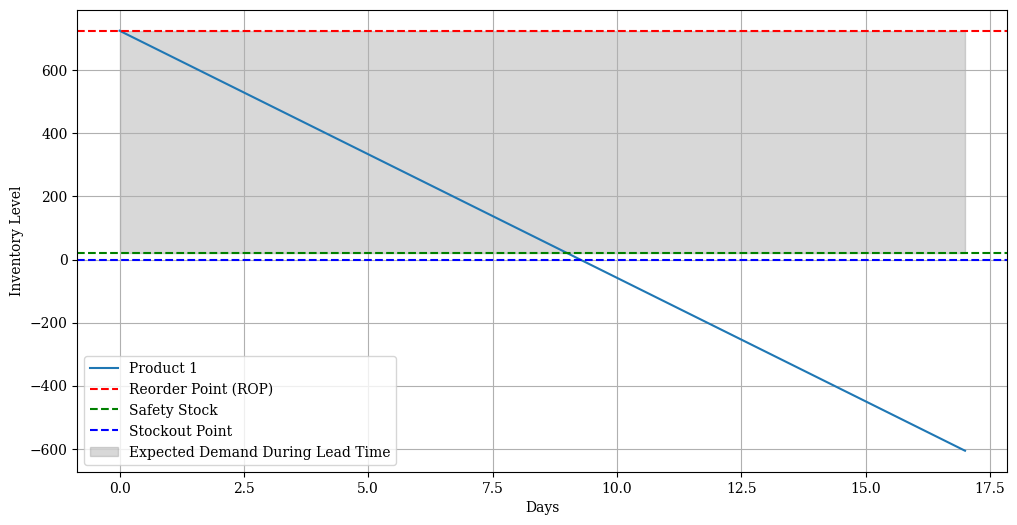

In [33]:
z_score = 1.65
lead_time = 9
std_dev_lead_time = 37.32
expected_demand_lead_time = 705

safety_stock = z_score * std_dev_lead_time / np.sqrt(lead_time)
reorder_point = safety_stock + expected_demand_lead_time

days = np.arange(0, 2 * lead_time, 1)
inventory_level = reorder_point - (days * (expected_demand_lead_time / lead_time))

plt.figure(figsize=(12, 6))
plt.plot(days, inventory_level, label='Product 1')
plt.axhline(y=reorder_point, color='r', linestyle='--', label='Reorder Point (ROP)')
plt.axhline(y=safety_stock, color='g', linestyle='--', label='Safety Stock')
plt.axhline(y=0, color='b', linestyle='--', label='Stockout Point')
plt.fill_between(days, safety_stock, reorder_point, color='gray', alpha=0.3, label='Expected Demand During Lead Time')

plt.title('Product 1: Reorder Point, Safety Stock, and Expected Demand During Lead Time')
plt.xlabel('Days')
plt.ylabel('Inventory Level')
plt.legend()
plt.grid(True)
plt.show()
